In [15]:
import torch
import torch.nn.functional as F
from captum.attr import IntegratedGradients, LayerIntegratedGradients, configure_interpretable_embedding_layer, remove_interpretable_embedding_layer
from captum.attr import visualization as viz
import numpy as np
import pandas as pd
from pyfaidx import Fasta
import matplotlib.pyplot as plt
from captum.attr._utils.input_layer_wrapper import ModelInputWrapper

from src.transformer_model import TranscriptTIS
from TIS_transformer import DNA2vec, prep_input

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower


%load_ext autoreload
%autoreload 2

gpus = True
device = torch.device('cuda') if gpus else torch.device('cpu')
max_seq_len = 25000

THRESH = 0.30
transcript_list = ['ENST00000507866', 'ENST00000400677'] #['ENST00000645482']
baseline_value = 0

USE_ARTICLE_DATA = False

transfer_checkpoint = 'lightning_logs/chr4_OpenProt-old-22+29_MLMhuman_MODELmedium_nc/version_0/checkpoints/epoch=17-step=211248.ckpt'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
def get_transcript_name_fasta(s):
    return s.split('|')[0]
def remove_version(s):
    return s.split('.')[0]

def vec2DNA(dna_vec):
    seq_list = ['A', 'T', 'C', 'G', 'N']
    dna_seq = []
    for id in dna_vec:
        dna_seq.append(seq_list[id])
    return ''.join(dna_seq)

Select of the transcript to predict

In [17]:
tsv = pd.read_csv('../TIS_transformer_utils/data/human_modified.tsv', sep='\t', skip_blank_lines=True, skiprows=1, 
                    dtype={'chr': str}, usecols=['transcript accession', 'protein accession numbers', 'protein type', 'start transcript coordinates', 'stop transcript coordinates', 'keep protein'])
tsv = tsv[tsv['keep protein']]

In [18]:
def tis_stop_from_tsv(tr_df, transcript_name, protein_name):
    protein_series = tr_df[tr_df['protein accession numbers'] == protein_name].iloc[0]
    tr_df = tr_df.drop(protein_series.name)
    true_tis = tr_df['start transcript coordinates'].unique()
    true_stop = tr_df['stop transcript coordinates'].unique()
    true_tis = np.insert(true_tis, 0, protein_series['start transcript coordinates']).astype(int) - 1
    true_stop = np.insert(true_stop, 0, protein_series['stop transcript coordinates']).astype(int) - 1
    return true_tis, true_stop

def get_sequence(transcript_list):
    data = np.load("data/GRCh38p13_unzip/chr4.npy", allow_pickle=True)
    dna_input = {}
    for tr in data:
        if tr[1] in transcript_list:
            dna_input[tr[1]] = vec2DNA(tr[0][:,0])
            label = np.argmax(tr[0][:,1])
    print(len(dna_input.keys()))
    assert len(dna_input.keys()) == len(transcript_list)
    return dna_input

In [19]:
"""if not USE_ARTICLE_DATA:
    genes = Fasta('../TIS_transformer_utils/data/ens95_all_trxps_human.fasta', key_function=get_transcript_name_fasta)
    genes_dict = {rec.name:rec[:].seq for rec in genes if 'N' not in rec[:].seq}
    dna_input = genes_dict[transcript_name]
    dna_input[true_tis[0]: true_tis[0]+10]
"""

"if not USE_ARTICLE_DATA:\n    genes = Fasta('../TIS_transformer_utils/data/ens95_all_trxps_human.fasta', key_function=get_transcript_name_fasta)\n    genes_dict = {rec.name:rec[:].seq for rec in genes if 'N' not in rec[:].seq}\n    dna_input = genes_dict[transcript_name]\n    dna_input[true_tis[0]: true_tis[0]+10]\n"

Load the model

In [20]:
tis_tr = TranscriptTIS.load_from_checkpoint(transfer_checkpoint)
tis_tr.to(device)
"done"

/home/julien/miniconda3/envs/TIS_trans/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/julien/miniconda3/envs/TIS_trans/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


'done'

Reading the dna sequence

In [21]:
def forward_prediction(x, mask, nt_mask):
    out = F.softmax(tis_tr.forward(x, mask, nt_mask, apply_dropout=False), dim=1)[:,1]
    return out.reshape(x.size(0), x.size(1)-2)

def generate_input_prediction(sequence):
    assert len(sequence) < 25000, f'input is longer than maximum input length: {max_seq_len}'
    x_data = [DNA2vec(sequence.upper())]
    input = prep_input(x_data[0], device)
    model_output = forward_prediction(input[0], input[1], input[2]).detach().cpu().numpy()
    model_tis = np.argwhere(model_output[0]>THRESH).flatten()
    return input, model_tis

In [29]:
def plot_attribution(attribution, model_tis, true_tis, true_stop, domain_tsv, name, window_size=30):
    domains_xmin = domain_tsv['d_start'].to_numpy() - 1
    domains_xmax = domain_tsv['d_end'].to_numpy() - 1
    domains_xmin += true_tis[0]
    domains_xmax += true_tis[0]
    fixed_attr = np.convolve(np.abs(attribution), np.ones(window_size)/window_size, mode='same')
    bottom, top = fixed_attr.min() - fixed_attr.max() * 5/100, fixed_attr.max() + fixed_attr.max() * 5/100
    plt.figure()
    plt.scatter(range(0,len(attribution)), np.abs(attribution), color='#b4c5e4', alpha=0.8, s=2)
    plt.plot(range(0, len(fixed_attr)), fixed_attr, color='#1f77b4', alpha=1)
    # predicted tis
    plt.vlines(model_tis, bottom, top, colors='red', linestyles='dashed')
    # true tis of the protein
    plt.vlines(true_tis[0], bottom, top, colors='blue', linestyles='dashed', alpha=0.6)
    plt.vlines(true_stop[0], bottom, top, colors='blue', linestyles='dotted', alpha=0.6)
    # other tis
    #plt.vlines(true_tis[1:], bottom, top, colors='green', linestyles='dashed', alpha=0.6)
    #plt.vlines(true_stop[1:], bottom, top, colors='green', linestyles='dotted', alpha=0.6)
    #domains
    for i in range(len(domains_xmax)):
        plt.hlines(-fixed_attr.max() * 5/100 / len(domains_xmax) * i, domains_xmin[i], domains_xmax[i], colors='red')  
    plt.ylim((bottom, top))  
    plt.savefig("outputs/test-"+name+".svg", format='svg')
    

In [23]:
# check if two forward prediction gives the same output
input = prep_input(DNA2vec('ATGTTTC'), device)
print(forward_prediction(input[0], input[1], input[2]))
print(forward_prediction(input[0], input[1], input[2]))

tensor([[1.1180e-03, 9.6201e-09, 1.2225e-08, 1.4014e-09, 9.0433e-10, 4.4114e-10,
         2.1751e-08]], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[1.0949e-06, 1.5905e-06, 4.8800e-06, 1.8628e-07, 4.0925e-07, 7.0552e-08,
         5.6463e-09]], device='cuda:0', grad_fn=<ViewBackward>)


Integrated gradients

In [24]:
tis_tr.zero_grad()
integrated_gradients = LayerIntegratedGradients(forward_prediction, [tis_tr.model.token_emb, tis_tr.model.pos_emb])

sequences = get_sequence(transcript_list)

2


/home/julien/miniconda3/envs/TIS_trans/lib/python3.8/site-packages/captum/attr/_core/layer/layer_integrated_gradients.py:102: UserWarning: Multiple layers provided. Please ensure that each layer is**not** solely solely dependent on the outputs ofanother layer. Please refer to the documentation for moredetail.
  warnings.warn(


In [25]:
domain_tsv = pd.read_csv("../TIS_transformer_utils/data/protein_domain_predictions.tsv", usecols=['t_acc', 'tt_acc', 'd_start', 'd_end', 'domain_len'], sep='\t')
domain_tsv['t_acc'] = domain_tsv['t_acc'].apply(remove_version)
domain_tsv

,t_acc,tt_acc,d_start,d_end,domain_len
0,ENST00000335137,ENSP00000334393.3,1,297,98
1,ENST00000335137,ENSP00000334393.3,1,297,98
2,ENST00000335137,ENSP00000334393.3,103,119,5
3,ENST00000335137,ENSP00000334393.3,148,196,16
4,ENST00000335137,ENSP00000334393.3,265,282,5
...,...,...,...,...,...
1690396,ENST00000520602,ENSP00000427745.2,602,777,58
1690397,ENST00000520602,ENSP00000427745.2,808,914,35
1690398,ENST00000520602,ENSP00000427745.2,790,912,40
1690399,ENST00000645399,ENSP00000494046.1,7,29,7


ENST00000507866
Attribution sum 4.221640558902318
Delta 0.7948410356524473
ENST00000400677
Attribution sum 0.00023399386493646722
Delta 2.1972403493997253e-05
The protein was not predicted
tis 225 not in tsv
Attribution sum 3.6932617268024113
Delta 0.40192319282749955


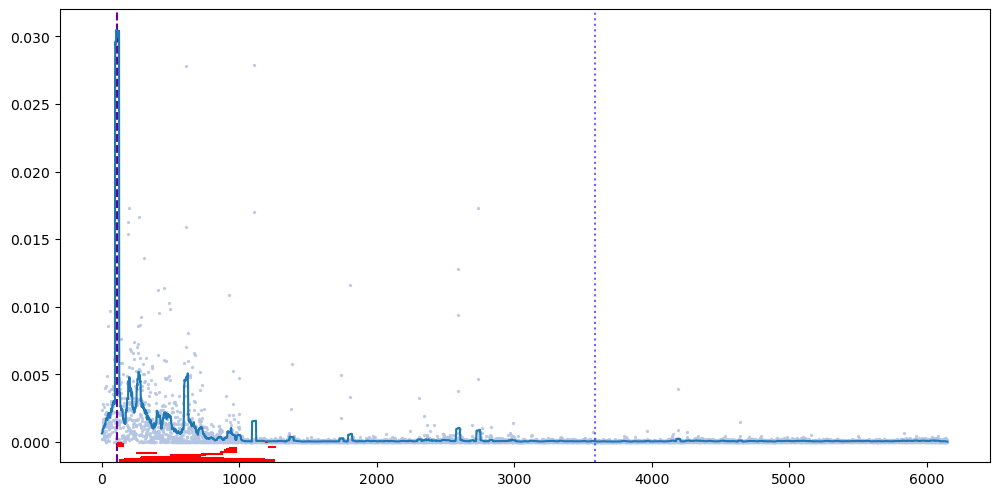

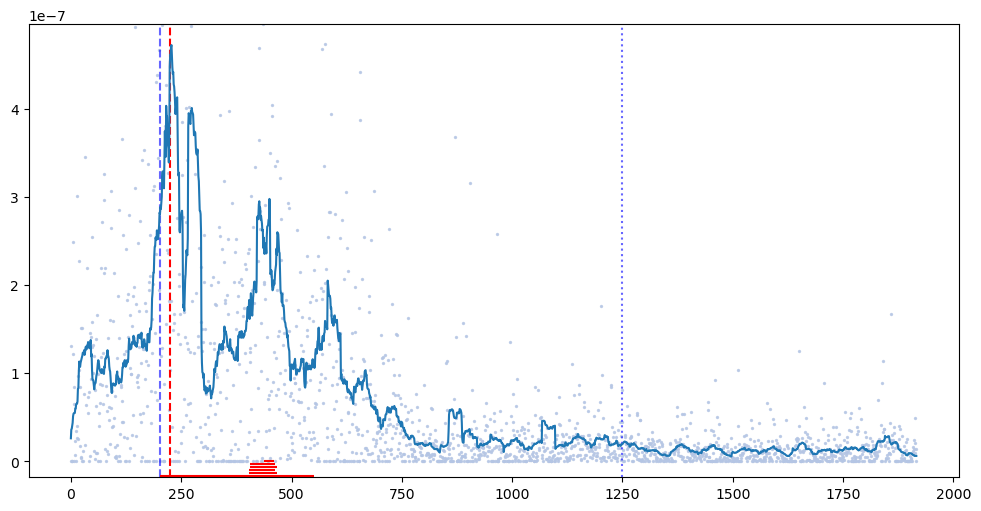

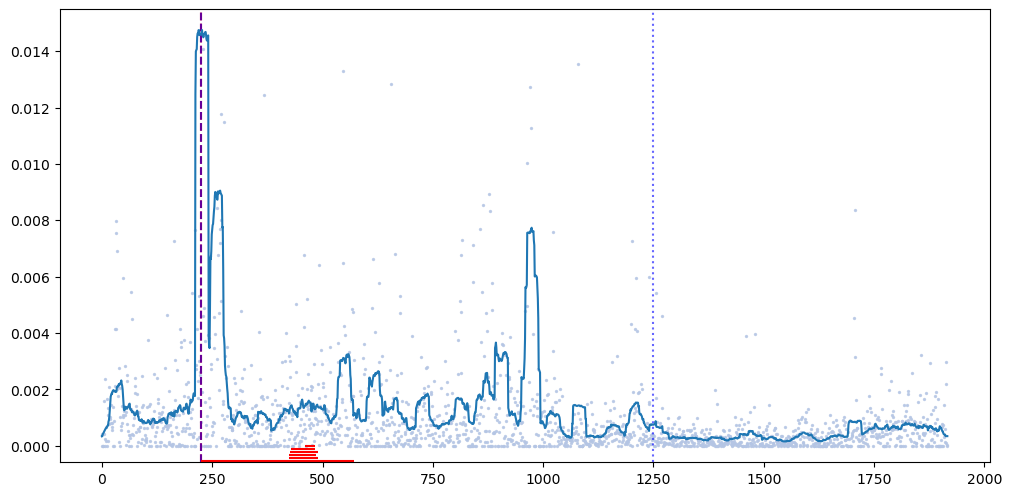

In [30]:
torch.cuda.empty_cache()
tsv_groups = tsv.groupby('transcript accession')
domain_groups = domain_tsv.groupby('tt_acc')


for transcript_name in transcript_list:
    print(transcript_name)
    tr_df = tsv_groups.get_group(transcript_name)
    protein_name = tr_df[tr_df['protein type'] == 'RefProt']['protein accession numbers'].iloc[0]
    domain_df = domain_groups.get_group(protein_name)
    domain_df = domain_df[domain_df['t_acc'] == transcript_name].sort_values('domain_len')
    
    name = protein_name + 'baseline' + str(baseline_value)
    true_tis, true_stop = tis_stop_from_tsv(tr_df, transcript_name, protein_name)
    input, pred_tis = generate_input_prediction(sequences[transcript_name])
    baseline = torch.ones_like(input[0]) * baseline_value
    attributions_ig, delta = integrated_gradients.attribute(inputs=input[0], baselines=baseline,target=int(true_tis[0]),
                                                            additional_forward_args = (input[1], input[2]), return_convergence_delta=True,
                                                            n_steps=50, internal_batch_size=3)
    attribution = attributions_ig[0].sum(dim=2).detach().cpu().numpy().flatten()[1:-1] + attributions_ig[1].sum(dim=2).detach().cpu().numpy().flatten()[1:-1]
    
    print("Attribution sum", torch.abs(attributions_ig[0]).sum(dim=2).detach().cpu().numpy().flatten()[1:-1].sum())
    print("Delta", delta.cpu().numpy()[0])
    plot_attribution(attribution, pred_tis, true_tis, true_stop, domain_df, name)

    if true_tis[0] not in pred_tis:
        print("The protein was not predicted")
    for tis in pred_tis:
        if tis not in tr_df['start transcript coordinates'].to_numpy() - 1:
            print(f'tis {tis} not in tsv')
            true_tis[0] = tis
            attributions_ig, delta = integrated_gradients.attribute(inputs=input[0], baselines=baseline,target=int(true_tis[0]),
                                                            additional_forward_args = (input[1], input[2]), return_convergence_delta=True,
                                                            n_steps=50, internal_batch_size=3)
            attribution = attributions_ig[0].sum(dim=2).detach().cpu().numpy().flatten()[1:-1] + attributions_ig[1].sum(dim=2).detach().cpu().numpy().flatten()[1:-1]
            print("Attribution sum", torch.abs(attributions_ig[0]).sum(dim=2).detach().cpu().numpy().flatten()[1:-1].sum())
            print("Delta", delta.cpu().numpy()[0])
            plot_attribution(attribution, pred_tis, true_tis, true_stop, domain_df, name)
            

In [ ]:
"""# window limits : 
alpha = 10
start = true_tis[0] #min(true_tis.min(), model_tis.min()) if len(model_tis) > 0 else true_tis.min()
stop = true_stop[0] #len(dna_input)#max(true_stop.max(), model_tis.max()) if len(model_tis) > 0 else true_stop.max()
print(start, stop)
Q1 = np.percentile(attribution, 25)
Q3 = np.percentile(attribution, 75)
v_max = Q3 + (Q3-Q1) * alpha
v_min = Q1 - (Q3-Q1) * alpha
print(v_max, v_min)"""

'# window limits : \nalpha = 10\nstart = true_tis[0] #min(true_tis.min(), model_tis.min()) if len(model_tis) > 0 else true_tis.min()\nstop = true_stop[0] #len(dna_input)#max(true_stop.max(), model_tis.max()) if len(model_tis) > 0 else true_stop.max()\nprint(start, stop)\nQ1 = np.percentile(attribution, 25)\nQ3 = np.percentile(attribution, 75)\nv_max = Q3 + (Q3-Q1) * alpha\nv_min = Q1 - (Q3-Q1) * alpha\nprint(v_max, v_min)'

In [ ]:
"""plt.scatter(range(0, len(dna_input)), attribution, s=8)
# predicted tis
plt.vlines(model_tis, attribution.min(), attribution.max(),colors='red', linestyles='dashed', alpha=1)
# true tis of the protein
plt.vlines(true_tis[0], attribution.min(), attribution.max(),colors='blue', linestyles='dashed', alpha=0.6)
plt.vlines(true_stop[0], attribution.min(), attribution.max(),colors='blue', linestyles='dotted', alpha=0.6)
# other tis
plt.vlines(true_tis[1:], attribution.min(), attribution.max(),colors='green', linestyles='dashed', alpha=0.6)
plt.vlines(true_stop[1:], attribution.min(), attribution.max(),colors='green', linestyles='dotted', alpha=0.6)
#domains
plt.hlines([0] * len(domains_xmax), domains_xmin, domains_xmax, colors='red')

if true_tis[0] not in model_tis:
    print("The protein was not predicted")
for tis in model_tis:
    if tis not in coordinates:
        print(f'tis {tis} not in tsv')
print(model_tis)
#plt.axis([start, stop, v_max, v_min])"""

'plt.scatter(range(0, len(dna_input)), attribution, s=8)\n# predicted tis\nplt.vlines(model_tis, attribution.min(), attribution.max(),colors=\'red\', linestyles=\'dashed\', alpha=1)\n# true tis of the protein\nplt.vlines(true_tis[0], attribution.min(), attribution.max(),colors=\'blue\', linestyles=\'dashed\', alpha=0.6)\nplt.vlines(true_stop[0], attribution.min(), attribution.max(),colors=\'blue\', linestyles=\'dotted\', alpha=0.6)\n# other tis\nplt.vlines(true_tis[1:], attribution.min(), attribution.max(),colors=\'green\', linestyles=\'dashed\', alpha=0.6)\nplt.vlines(true_stop[1:], attribution.min(), attribution.max(),colors=\'green\', linestyles=\'dotted\', alpha=0.6)\n#domains\nplt.hlines([0] * len(domains_xmax), domains_xmin, domains_xmax, colors=\'red\')\n\nif true_tis[0] not in model_tis:\n    print("The protein was not predicted")\nfor tis in model_tis:\n    if tis not in coordinates:\n        print(f\'tis {tis} not in tsv\')\nprint(model_tis)\n#plt.axis([start, stop, v_max, v_